In [1]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1000)
T_vals = (600, 700, 800, 900, 1000)
P_vals = (0.1, 1, 10, 100)
T_drop = (300,)  # Drop 300 K rates for fit
A_fill = 1e-20

# stoich = "C5H9O"
# clear_labels = []
stoich = "C5H7O2"
clear_labels = ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [2]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [3]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [4]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [5]:
clear_keys = [mess.surf.node_key_from_label(surf_out, label) for label in clear_labels]

print(f"Clearing out rates for nodes {clear_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_keys)

Clearing out rates for nodes [1, 20]


In [6]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[(2, 7), (2, 8), (2, 9), (2, 11), (2, 24), (2, 27), (3, 7), (3, 9), (4, 7), (4, 8), (4, 9), (4, 11), (4, 24), (4, 27), (5, 9), (5, 11), (6, 24), (7, 2), (7, 3), (7, 4), (7, 23), (7, 24), (8, 2), (8, 4), (8, 24), (9, 2), (9, 3), (9, 4), (9, 5), (9, 24), (10, 24), (11, 2), (11, 4), (11, 5), (11, 22), (11, 24), (22, 11), (23, 7), (24, 2), (24, 4), (24, 6), (24, 7), (24, 8), (24, 9), (24, 10), (24, 11), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 10), (27, 12), (27, 21), (27, 22), (27, 23), (27, 24), (27, 25), (27, 26)]


In [7]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(2, 4), (2, 5), (2, 10), (2, 12), (2, 22), (2, 23), (2, 26), (3, 4), (3, 5), (3, 8), (3, 10), (3, 11), (3, 23), (3, 25), (3, 26), (4, 2), (4, 3), (4, 6), (4, 12), (4, 22), (4, 23), (4, 26), (5, 2), (5, 3), (5, 6), (5, 7), (5, 8), (5, 22), (5, 25), (5, 26), (6, 4), (6, 5), (6, 10), (6, 11), (6, 12), (6, 23), (6, 25), (6, 26), (7, 5), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 25), (7, 26), (8, 3), (8, 5), (8, 7), (8, 9), (8, 11), (8, 12), (8, 25), (8, 26), (9, 7), (9, 8), (9, 11), (9, 25), (9, 26), (10, 2), (10, 3), (10, 6), (10, 7), (10, 12), (10, 22), (10, 25), (10, 26), (11, 3), (11, 6), (11, 7), (11, 8), (11, 9), (11, 12), (11, 25), (11, 26), (12, 2), (12, 4), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (12, 11), (12, 24), (12, 25), (21, 7), (21, 8), (21, 9), (21, 11), (21, 24), (21, 26), (22, 2), (22, 4), (22, 5), (22, 7), (22, 8), (22, 9), (22, 10), (22, 12), (22, 23), (22, 24), (22, 25), (22, 26), (23, 2), (23, 3), (23, 4), (23, 6),

In [8]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [9]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[(3, 1), (5, 1), (6, 20), (10, 20), (1, 3), (1, 5), (20, 6), (20, 10), (27, 7), (27, 8), (27, 9), (27, 11)]


In [10]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [11]:
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

In [13]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [14]:
print("Clearing unfittable pressures.")
surf_out = mess.surf.clear_unfittable_pressures(surf_out)

Clearing unfittable pressures.


In [15]:
surf_out = mess.surf.fit_rates(surf_out, T_drop=T_drop, A_fill=A_fill)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=1.2069316255001423e-18 b=8.738403879519137 E=13901.887312887004 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=3.240545788835501e-09 b=6.475827349099434 E=35920.019025636786 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=2.3870396185874683e-17 b=8.213278442882824 E=5086.954098273543 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWar

Direct rates:
(2, 3) S(1206)r0 = S(1210)r0


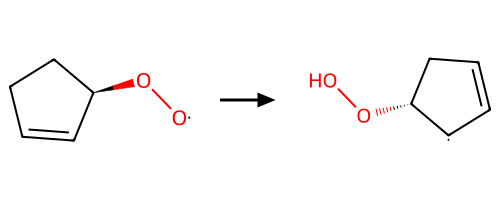

alt.LayerChart(...)

Median branching fraction: 1.6609671319014034e-07
[[3.37449301e-08 4.15758030e-08 8.37394327e-08 1.67171504e-07]
 [3.18007506e-08 4.73495104e-08 1.20899369e-07 3.12200392e-07]
 [4.97677364e-08 5.85820994e-08 1.65021923e-07 5.02703811e-07]
 [1.79081759e-07 9.75602367e-08 2.22506778e-07 7.31252473e-07]
 [8.82698372e-07 2.38047012e-07 3.16052390e-07 9.93056265e-07]]

(2, 21) S(1206)r0 = C5H6(478) + HO2(8)


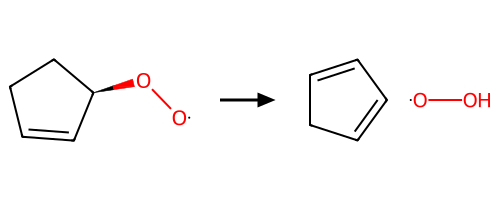

alt.LayerChart(...)

Median branching fraction: 9.01973847998655e-06
[[2.36842041e-07 1.30967971e-06 4.74740253e-06 1.02871264e-05]
 [4.62298622e-07 2.11673157e-06 7.75235052e-06 1.94690982e-05]
 [1.26625220e-06 3.50320955e-06 1.14943016e-05 3.06828029e-05]
 [7.27469902e-06 7.47493900e-06 1.70360439e-05 4.39184178e-05]
 [7.00609317e-05 2.19652471e-05 2.71117050e-05 6.01077620e-05]]

(3, 6) S(1210)r0 = S(1209)r0


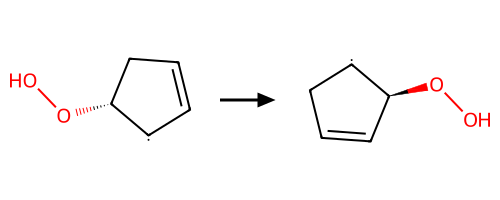

alt.LayerChart(...)

Median branching fraction: 2.4345908824678896e-08
[[           nan 5.14678679e-09 2.43459088e-08 4.12679129e-08]
 [7.15665911e-10 7.55031518e-09 5.74522346e-08 1.74689407e-07]
 [9.70039877e-10 8.96840237e-09 8.20326052e-08 4.30697183e-07]
 [1.53998977e-09 1.08227430e-08 9.34721763e-08 7.03181252e-07]
 [2.68795890e-09 1.34340786e-08 9.89763761e-08 8.78595023e-07]]

(3, 22) S(1210)r0 = OH(4) + S(1288)rs0


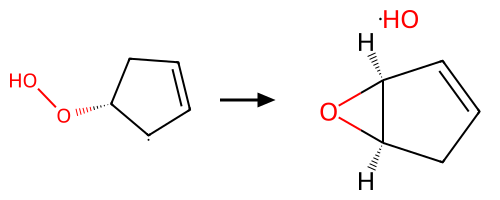

alt.LayerChart(...)

Median branching fraction: 0.747886459612761
[[0.8779782  0.84036116 0.82466233 0.82142798]
 [0.8443894  0.78678265 0.75156034 0.74174912]
 [0.81823934 0.74421258 0.69067568 0.66808933]
 [0.79608836 0.71151281 0.6426653  0.60769852]
 [0.777668   0.68589843 0.60720507 0.55907601]]

(4, 5) S(1206)r1 = S(1210)r1


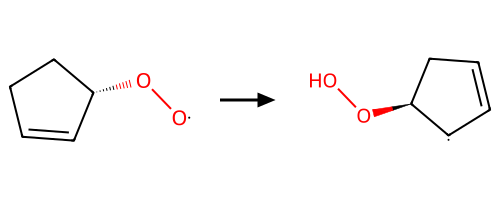

alt.LayerChart(...)

Median branching fraction: 1.6609671319014034e-07
[[3.37449301e-08 4.15758030e-08 8.37394327e-08 1.67171504e-07]
 [3.18007506e-08 4.73495104e-08 1.20899369e-07 3.12200392e-07]
 [4.97677364e-08 5.85820994e-08 1.65021923e-07 5.02703811e-07]
 [1.79081759e-07 9.75602367e-08 2.22506778e-07 7.31252473e-07]
 [8.82698372e-07 2.38047012e-07 3.16052390e-07 9.93056265e-07]]

(4, 21) S(1206)r1 = C5H6(478) + HO2(8)


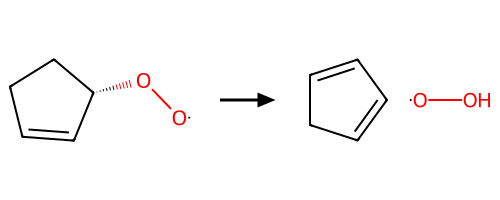

alt.LayerChart(...)

Median branching fraction: 9.01973847998655e-06
[[2.36842041e-07 1.30967971e-06 4.74740253e-06 1.02871264e-05]
 [4.62298622e-07 2.11673157e-06 7.75235052e-06 1.94690982e-05]
 [1.26625220e-06 3.50320955e-06 1.14943016e-05 3.06828029e-05]
 [7.27469902e-06 7.47493900e-06 1.70360439e-05 4.39184178e-05]
 [7.00609317e-05 2.19652471e-05 2.71117050e-05 6.01077620e-05]]

(5, 10) S(1210)r1 = S(1209)r1


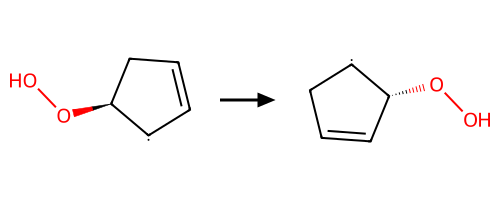

alt.LayerChart(...)

Median branching fraction: 2.4345908824678896e-08
[[           nan 5.14678679e-09 2.43459088e-08 4.12679129e-08]
 [7.15665911e-10 7.55031518e-09 5.74522346e-08 1.74689407e-07]
 [9.70039877e-10 8.96840237e-09 8.20326052e-08 4.30697183e-07]
 [1.53998977e-09 1.08227430e-08 9.34721763e-08 7.03181252e-07]
 [2.68795890e-09 1.34340786e-08 9.89763761e-08 8.78595023e-07]]

(5, 23) S(1210)r1 = OH(4) + S(1288)rs1


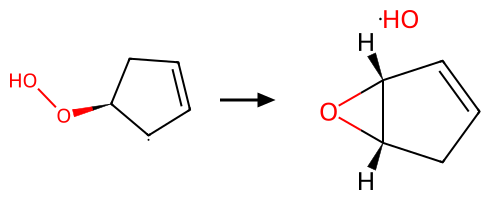

alt.LayerChart(...)

Median branching fraction: 0.747886459612761
[[0.8779782  0.84036116 0.82466233 0.82142798]
 [0.8443894  0.78678265 0.75156034 0.74174912]
 [0.81823934 0.74421258 0.69067568 0.66808933]
 [0.79608836 0.71151281 0.6426653  0.60769852]
 [0.777668   0.68589843 0.60720507 0.55907601]]

(6, 2) S(1209)r0 = S(1206)r0


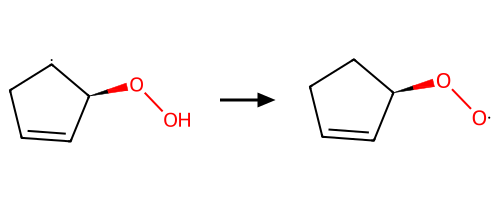

alt.LayerChart(...)

Median branching fraction: 4.601804783743776e-09 (reverse direction)
[[           nan 3.47023839e-10 1.39565721e-09 5.54705444e-09]
 [           nan 4.64561234e-10 2.39869493e-09 1.46006499e-08]
 [           nan 7.34228980e-10 3.65655513e-09 2.83596431e-08]
 [2.22061382e-09 1.67221053e-09            nan 4.54328460e-08]
 [1.67348513e-08 5.57246416e-09 1.09220826e-08 6.62037510e-08]]

(6, 7) S(1209)r0 = C5O2pkpfsder0


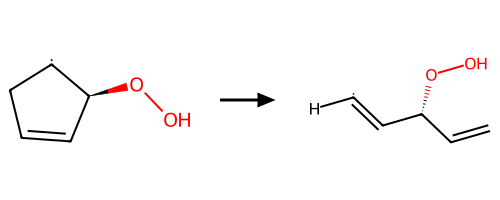

alt.LayerChart(...)

Median branching fraction: 6.060102506874066e-12
[[           nan            nan 4.38022068e-14 3.60786006e-12]
 [           nan            nan 7.60638872e-13 8.13008266e-11]
 [           nan 1.45345958e-14 6.06010251e-12 7.23476187e-10]
 [           nan 1.33212882e-13 3.02949719e-11 3.53802862e-09]
 [           nan 8.73593966e-13 1.13496241e-10 1.17861843e-08]]

(6, 8) S(1209)r0 = C5O2sidwaoee


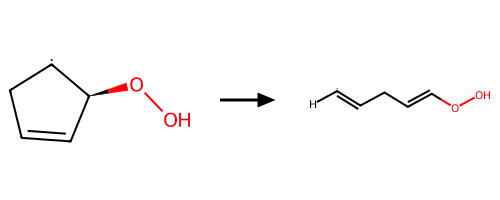

alt.LayerChart(...)

Median branching fraction: 3.543338624237842e-11
[[           nan            nan 3.65584310e-13 2.05202297e-11]
 [           nan            nan 5.20844245e-12 3.98139850e-10]
 [           nan 1.05915313e-13 3.54333862e-11 3.13198158e-09]
 [           nan 8.34713228e-13 1.56722807e-10 1.39230769e-08]
 [           nan 4.91898837e-12 5.33980524e-10 4.29353857e-08]]

(6, 22) S(1209)r0 = OH(4) + S(1288)rs0


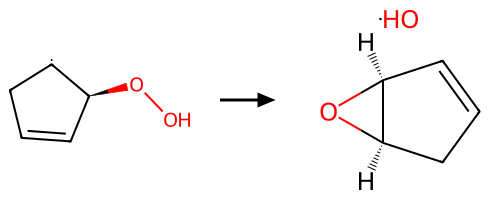

alt.LayerChart(...)

Median branching fraction: 0.00043943650953278464 (reverse direction)
[[8.18114882e-05 2.43555109e-04 5.23502898e-04 7.63465251e-04]
 [9.69293793e-05 3.33401159e-04 9.79304607e-04 1.94369721e-03]
 [8.70636594e-05 3.55370121e-04 1.22867240e-03 3.37452856e-03]
 [7.00471764e-05 3.29788111e-04 1.28115537e-03 4.34104216e-03]
 [5.97597039e-05 2.82211392e-04 1.22474251e-03 4.64650146e-03]]

(7, 27) C5O2pkpfsder0 = C2H2(40) + C3H4O(165) + OH(4)


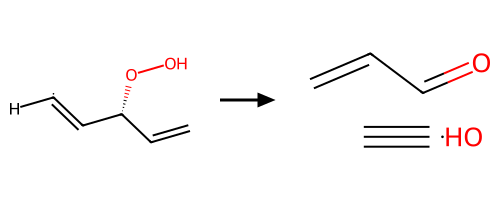

alt.LayerChart(...)

/tmp/ipykernel_40645/989391165.py:34: RuntimeWarning: All-NaN slice encountered
  rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])


Median branching fraction: 0.9999536469364256
[[1.         1.         0.79902558 0.03871408]
 [1.         1.         0.98454177 0.28719008]
 [1.         0.99999097 0.99837193 0.75301205]
 [1.         0.99999576 0.99971295 0.94825051]
 [1.         0.99999713 0.99991632 0.9885512 ]]

(8, 27) C5O2sidwaoee = C2H2(40) + C3H4O(165) + OH(4)


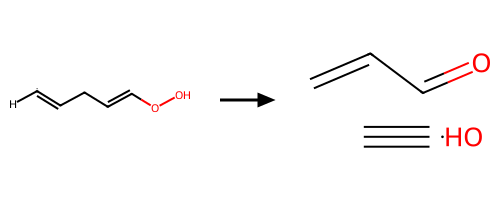

alt.LayerChart(...)

/tmp/ipykernel_40645/989391165.py:34: RuntimeWarning: All-NaN slice encountered
  rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])


Median branching fraction: 0.998095702236858
[[1.         1.         0.06850061 0.00129734]
 [1.         1.         0.57754979 0.01560854]
 [1.         0.99934688 0.9336801  0.11994517]
 [1.         0.99974816 0.98831031 0.47488584]
 [1.         0.99984945 0.99684452 0.8239466 ]]

(9, 27) C5O2sidwaoez = C2H2(40) + C3H4O(165) + OH(4)


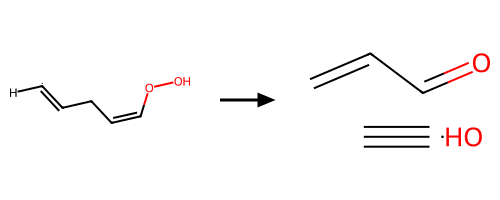

alt.LayerChart(...)

/tmp/ipykernel_40645/989391165.py:34: RuntimeWarning: All-NaN slice encountered
  rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])


Median branching fraction: 1.0
[[1.         1.         1.         1.        ]
 [1.         1.         1.         0.44946809]
 [1.         1.         0.99944073 0.85497305]
 [1.         0.99999848 0.99991156 0.97243986]
 [1.         0.99999901 0.99997668 0.99422102]]

(10, 4) S(1209)r1 = S(1206)r1


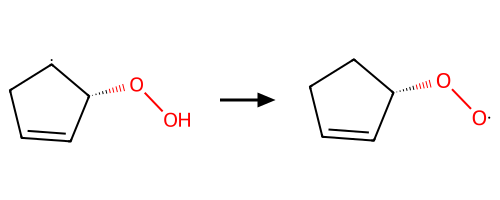

alt.LayerChart(...)

Median branching fraction: 4.601804783743776e-09 (reverse direction)
[[           nan 3.47023839e-10 1.39565721e-09 5.54705444e-09]
 [           nan 4.64561234e-10 2.39869493e-09 1.46006499e-08]
 [           nan 7.34228980e-10 3.65655513e-09 2.83596431e-08]
 [2.22061382e-09 1.67221053e-09            nan 4.54328460e-08]
 [1.67348513e-08 5.57246416e-09 1.09220826e-08 6.62037510e-08]]

(10, 8) S(1209)r1 = C5O2sidwaoee


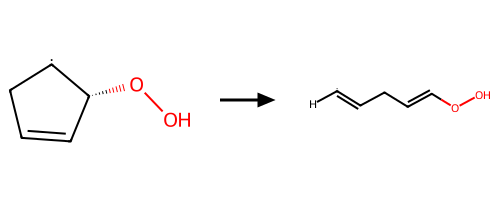

alt.LayerChart(...)

Median branching fraction: 3.543338624237842e-11
[[           nan            nan 3.65584310e-13 2.05202297e-11]
 [           nan            nan 5.20844245e-12 3.98139850e-10]
 [           nan 1.05915313e-13 3.54333862e-11 3.13198158e-09]
 [           nan 8.34713228e-13 1.56722807e-10 1.39230769e-08]
 [           nan 4.91898837e-12 5.33980524e-10 4.29353857e-08]]

(10, 11) S(1209)r1 = C5O2pkpfsder1


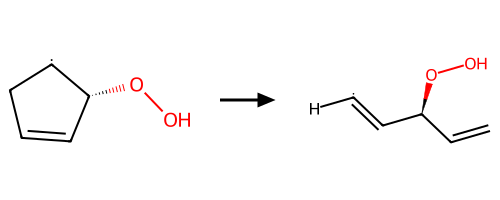

alt.LayerChart(...)

Median branching fraction: 6.060102506874066e-12
[[           nan            nan 4.38022068e-14 3.60786006e-12]
 [           nan            nan 7.60638872e-13 8.13008266e-11]
 [           nan 1.45345958e-14 6.06010251e-12 7.23476187e-10]
 [           nan 1.33212882e-13 3.02949719e-11 3.53802862e-09]
 [           nan 8.73593966e-13 1.13496241e-10 1.17861843e-08]]

(10, 23) S(1209)r1 = OH(4) + S(1288)rs1


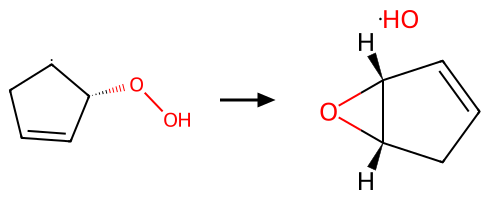

alt.LayerChart(...)

Median branching fraction: 0.00043943650953278464 (reverse direction)
[[8.18114882e-05 2.43555109e-04 5.23502898e-04 7.63465251e-04]
 [9.69293793e-05 3.33401159e-04 9.79304607e-04 1.94369721e-03]
 [8.70636594e-05 3.55370121e-04 1.22867240e-03 3.37452856e-03]
 [7.00471764e-05 3.29788111e-04 1.28115537e-03 4.34104216e-03]
 [5.97597039e-05 2.82211392e-04 1.22474251e-03 4.64650146e-03]]

(11, 27) C5O2pkpfsder1 = C2H2(40) + C3H4O(165) + OH(4)


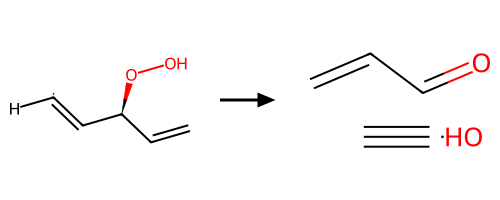

alt.LayerChart(...)

/tmp/ipykernel_40645/989391165.py:34: RuntimeWarning: All-NaN slice encountered
  rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])


Median branching fraction: 0.9999536469364256
[[1.         1.         0.79902558 0.03871408]
 [1.         1.         0.98454177 0.28719008]
 [1.         0.99999097 0.99837193 0.75301205]
 [1.         0.99999576 0.99971295 0.94825051]
 [1.         0.99999713 0.99991632 0.9885512 ]]

(12, 3) S(602) = S(1210)r0


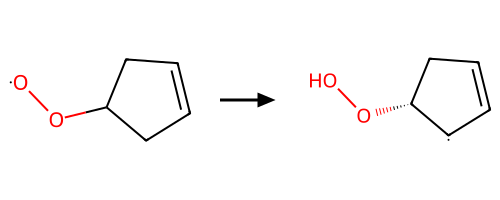

alt.LayerChart(...)

Median branching fraction: 0.00012641202449585576 (reverse direction)
[[9.46948644e-05 1.11105239e-04 1.21930750e-04 1.24786308e-04]
 [9.63779356e-05 1.27628759e-04 1.58951182e-04 1.72938623e-04]
 [9.04449992e-05 1.32592396e-04 1.89970244e-04 2.30948647e-04]
 [8.27490845e-05 1.25195290e-04 1.99877610e-04 2.81094028e-04]
 [7.90151677e-05 1.11528200e-04 1.88205079e-04 3.06356542e-04]]

(12, 5) S(602) = S(1210)r1


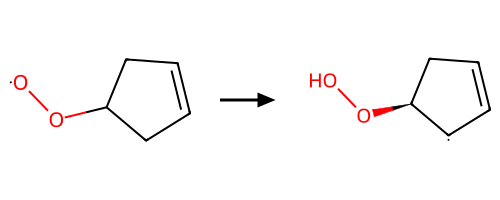

alt.LayerChart(...)

Median branching fraction: 0.00012641202449585576 (reverse direction)
[[9.46948644e-05 1.11105239e-04 1.21930750e-04 1.24786308e-04]
 [9.63779356e-05 1.27628759e-04 1.58951182e-04 1.72938623e-04]
 [9.04449992e-05 1.32592396e-04 1.89970244e-04 2.30948647e-04]
 [8.27490845e-05 1.25195290e-04 1.99877610e-04 2.81094028e-04]
 [7.90151677e-05 1.11528200e-04 1.88205079e-04 3.06356542e-04]]

(12, 21) S(602) = C5H6(478) + HO2(8)


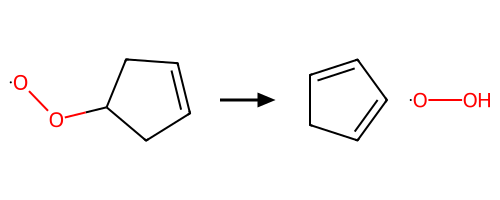

alt.LayerChart(...)

Median branching fraction: 0.0007449562333150291 (reverse direction)
[[0.00054982 0.00060075 0.00058536 0.00059637]
 [0.00055292 0.00082238 0.0008744  0.00089466]
 [0.00038459 0.00084993 0.00113421 0.00120238]
 [0.00021628 0.00066754 0.00125442 0.00151065]
 [0.0001176  0.00042041 0.00114955 0.00175409]]

(21, 3) C5H6(478) + HO2(8) = S(1210)r0


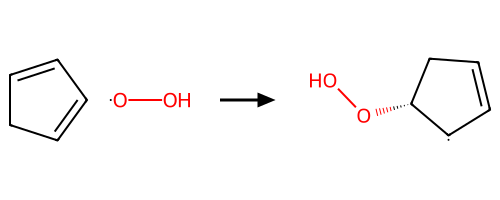

alt.LayerChart(...)

Median branching fraction: 0.2519667410075611 (reverse direction)
[[0.12192692 0.15952705 0.17521207 0.17843459]
 [0.15551416 0.21308948 0.24827877 0.25806567]
 [0.18167017 0.25565471 0.3091334  0.33167074]
 [0.20382881 0.2883619  0.35713426 0.39201462]
 [0.22225271 0.3139899  0.39260629 0.44061376]]

(21, 5) C5H6(478) + HO2(8) = S(1210)r1


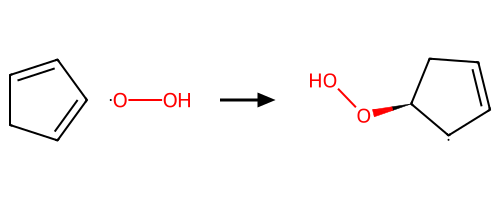

alt.LayerChart(...)

Median branching fraction: 0.2519667410075611 (reverse direction)
[[0.12192692 0.15952705 0.17521207 0.17843459]
 [0.15551416 0.21308948 0.24827877 0.25806567]
 [0.18167017 0.25565471 0.3091334  0.33167074]
 [0.20382881 0.2883619  0.35713426 0.39201462]
 [0.22225271 0.3139899  0.39260629 0.44061376]]

(21, 6) C5H6(478) + HO2(8) = S(1209)r0


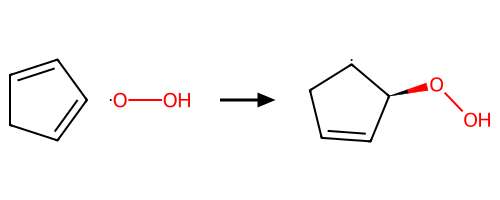

alt.LayerChart(...)

Median branching fraction: 0.0028039460594111217
[[0.00071818 0.00251096 0.00547813 0.00748881]
 [0.00043432 0.0019983  0.00626204 0.01186103]
 [0.00026079 0.00138445 0.00550508 0.01449691]
 [0.00017267 0.00093251 0.0042525  0.01447178]
 [0.00012348 0.00060887 0.00309693 0.0124979 ]]

(21, 10) C5H6(478) + HO2(8) = S(1209)r1


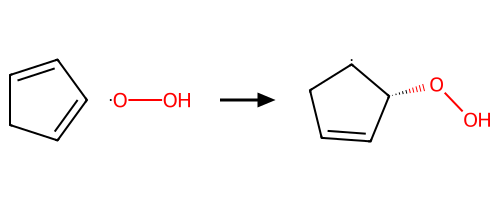

alt.LayerChart(...)

Median branching fraction: 0.0028039460594111217
[[0.00071818 0.00251096 0.00547813 0.00748881]
 [0.00043432 0.0019983  0.00626204 0.01186103]
 [0.00026079 0.00138445 0.00550508 0.01449691]
 [0.00017267 0.00093251 0.0042525  0.01447178]
 [0.00012348 0.00060887 0.00309693 0.0124979 ]]

(25, 2) C5H7(500) + O2(6) = S(1206)r0


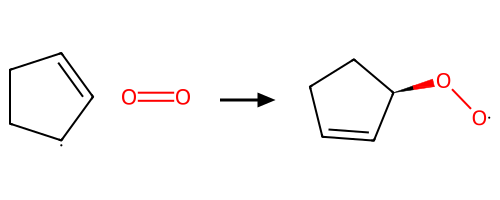

alt.LayerChart(...)

Median branching fraction: 0.4961887525413655
[[0.49956355 0.49991083 0.49997568 0.49999276]
 [0.49411851 0.49884342 0.49980036 0.49995644]
 [0.45786841 0.48796841 0.49825899 0.49976469]
 [0.33783784 0.4276885  0.48546279 0.4986408 ]
 [0.16633466 0.28187919 0.41984057 0.49244015]]

(25, 4) C5H7(500) + O2(6) = S(1206)r1


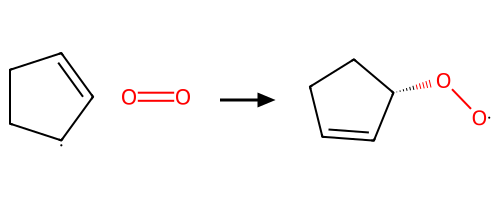

alt.LayerChart(...)

Median branching fraction: 0.4961887525413655
[[0.49956355 0.49991083 0.49997568 0.49999276]
 [0.49411851 0.49884342 0.49980036 0.49995644]
 [0.45786841 0.48796841 0.49825899 0.49976469]
 [0.33783784 0.4276885  0.48546279 0.4986408 ]
 [0.16633466 0.28187919 0.41984057 0.49244015]]

(26, 12) C5H7(504) + O2(6) = S(602)


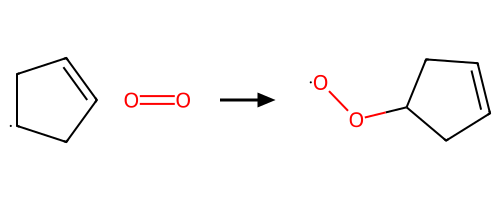

alt.LayerChart(...)

Median branching fraction: 0.8889847376307557 (reverse direction)
[[0.80744386 0.8175654  0.8199501  0.82135662]
 [0.8684725  0.88073632 0.88242167 0.88331869]
 [0.88870798 0.90407222 0.90744622 0.90745266]
 [0.8892615  0.9133263  0.9186049  0.91808985]
 [0.86655199 0.91396417 0.92402464 0.92367621]]



In [16]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
        )
    )

    key1, key2 = rate_key
    rev_rate_key = (key2, key1)
    min_rate_key = min(
        rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])
    )
    branch_frac_arr = branch_frac_dct[min_rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    if rate_key == min_rate_key:
        print(f"Median branching fraction: {branch_frac}")
    else:
        print(f"Median branching fraction: {branch_frac} (reverse direction)")

    print(branch_frac_arr)
    print()

In [17]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )
    key1, key2 = rate_key
    rev_rate_key = (key2, key1)
    min_rate_key = min(
        rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])
    )
    branch_frac_arr = branch_frac_dct[min_rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    if rate_key == min_rate_key:
        print(f"Median branching fraction: {branch_frac}")
    else:
        print(f"Median branching fraction: {branch_frac} (reverse direction)")

    print(branch_frac_arr)
    print()

Well-skipping rates:
(21, 22)


alt.LayerChart(...)

Median branching fraction: 0.15588189893123666 (reverse direction)
[[1.60364238e-01 4.29328012e-02 6.91953993e-03 8.58898408e-04]
 [4.26829372e-01 1.51399560e-01 3.27157070e-02 4.73037913e-03]
 [7.22892202e-01 3.64232219e-01 1.05767160e-01 1.88209000e-02]
 [8.90562614e-01 6.18352708e-01 2.50407640e-01 5.63872024e-02]
 [9.57190063e-01 8.06318263e-01 4.51934506e-01 1.34384111e-01]]

(21, 23)


alt.LayerChart(...)

Median branching fraction: 0.15588189893123666 (reverse direction)
[[1.60364238e-01 4.29328012e-02 6.91953993e-03 8.58898408e-04]
 [4.26829372e-01 1.51399560e-01 3.27157070e-02 4.73037913e-03]
 [7.22892202e-01 3.64232219e-01 1.05767160e-01 1.88209000e-02]
 [8.90562614e-01 6.18352708e-01 2.50407640e-01 5.63872024e-02]
 [9.57190063e-01 8.06318263e-01 4.51934506e-01 1.34384111e-01]]

(25, 21)


alt.LayerChart(...)

Median branching fraction: 0.007622494917268912
[[8.72893306e-04 1.78338976e-04 4.86339983e-05 1.44877419e-05]
 [1.17629706e-02 2.31315542e-03 3.99281851e-04 8.71211221e-05]
 [8.42631781e-02 2.40631751e-02 3.48201922e-03 4.70620744e-04]
 [3.24324324e-01 1.44622991e-01 2.90744198e-02 2.71839663e-03]
 [6.67330677e-01 4.36241611e-01 1.60318866e-01 1.51196976e-02]]

